<a href="https://colab.research.google.com/github/NatBrian/mediapipe-hand-recognition/blob/brian/keypoint_training_transformer_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Hand Gesture Recognition with Self-Attention on Mediapipe Keypoints

This notebook implements and explains an **advanced Transformer-style self-attention model** for **static hand gesture classification** using **21 Mediapipe hand landmarks** (x, y). We treat **each joint as a token** and let the model learn **relationships between joints** via **multi-head self-attention**.


## 1. Project Overview

- **Task:** Multiclass classification of **10 static hand gestures**.  
- **Input:** 21 hand landmarks → 42 features (`[x1, y1, …, x21, y21]`).  
- **Labels:** Integer class IDs in column 0 of the CSV.  
- **Dataset size:** ~28,677 rows (each row = 1 sample).  
- **Why attention?** Self-attention lets each joint attend to every other joint. It can naturally model **pairwise and higher-order relationships** between fingers (e.g., thumb-index proximity) that are useful for distinguishing gestures.


## 2. Setup & Imports


In [49]:
# If running on Colab and xgboost isn't present:
try:
    import xgboost  # noqa: F401
except Exception:
    !pip -q install xgboost


In [50]:
import os, datetime, time, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML / Metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Baselines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# XGBoost
from xgboost import XGBClassifier

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 3. Dataset Loading and Basic Understanding

The first column is the integer label; the next 42 columns are the 21 pairs of (x, y). Adjust `DATA_PATH` if needed to match your environment.


In [51]:
# Path consistent with prior notebooks. Adjust if your dataset file name differs.
# Examples used before:
#   "../data/keypoint.csv"
#   "keypoint_10gestures.csv"
DATA_PATH = "keypoint_10gestures.csv" # "../data/keypoint.csv"

NUM_LANDMARKS = 21
FEATURES_PER_LANDMARK = 2
INPUT_DIM = NUM_LANDMARKS * FEATURES_PER_LANDMARK  # 42

# Load full data for quick checks (1 label + 42 features expected)
data = np.loadtxt(DATA_PATH, delimiter=',', dtype=np.float32)
print("Raw data shape:", data.shape)

assert data.shape[1] == 1 + INPUT_DIM, "Expected 1 label + 42 features."

# Split into features and labels to mirror existing notebooks
X_dataset = np.loadtxt(DATA_PATH, delimiter=',', dtype=np.float32,
                       usecols=list(range(1, INPUT_DIM + 1)))
y_dataset = np.loadtxt(DATA_PATH, delimiter=',', dtype=np.int32, usecols=(0,))

labels = np.unique(y_dataset)
NUM_CLASSES = len(labels)

print("X_dataset shape:", X_dataset.shape)  # (N, 42)
print("y_dataset shape:", y_dataset.shape)  # (N,)
print("Classes:", labels)


Raw data shape: (28677, 43)
X_dataset shape: (28677, 42)
y_dataset shape: (28677,)
Classes: [0 1 2 3 4 5 6 7 8 9]


## 4. Exploratory Data Analysis


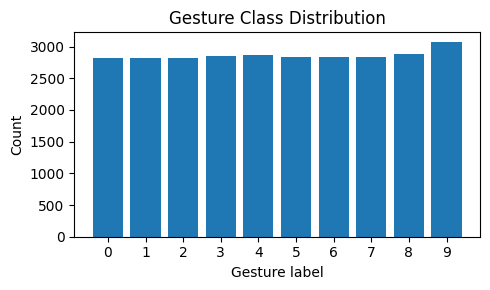

,count,mean,std,min,25%,50%,75%,max
f1,28677.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
f2,28677.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
f3,28677.0,0.001332,0.226744,-0.645570,-0.197080,0.000000,0.195402,0.631579
f4,28677.0,-0.073445,0.188270,-0.676056,-0.224806,-0.104072,0.057778,0.500000
f5,28677.0,-0.001838,0.403496,-1.000000,-0.354167,0.000000,0.348387,1.000000
f6,28677.0,-0.176919,0.358423,-1.000000,-0.462687,-0.263158,0.054545,0.924528
f7,28677.0,-0.002760,0.507748,-1.000000,-0.430493,0.010714,0.429412,1.000000
f8,28677.0,-0.258880,0.494108,-1.000000,-0.647368,-0.395833,0.022599,1.000000
f9,28677.0,-0.005002,0.567046,-1.000000,-0.459330,0.007752,0.458167,1.000000
f10,28677.0,-0.309879,0.599375,-1.000000,-0.752381,-0.486034,-0.016260,1.000000


In [52]:
# Class distribution
unique_labels, counts = np.unique(y_dataset, return_counts=True)
plt.figure(figsize=(5, 3))
plt.bar(unique_labels, counts)
plt.xticks(unique_labels)
plt.xlabel("Gesture label")
plt.ylabel("Count")
plt.title("Gesture Class Distribution")
plt.tight_layout()
plt.show()

# Basic feature statistics
df = pd.DataFrame(X_dataset, columns=[f"f{i}" for i in range(1, INPUT_DIM+1)])
display(df.describe().T.head(10))  # show a few rows of stats


**Why attention can help:** The coordinates of different joints are not independent. Static gestures depend on **relative geometry**—eg., which fingers are folded/extended and how far they are from each other. Self-attention explicitly learns **inter-joint relations**, which a plain MLP must approximate indirectly.


## 5. Train/Test Split and Evaluation Setup
We mirror the prior split: **75% training, 25% test**, **stratified**, `RANDOM_SEED=42`.


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset, y_dataset,
    train_size=0.75,
    random_state=RANDOM_SEED,
    stratify=y_dataset
)

print("Training set:", X_train.shape, " Test set:", X_test.shape)


Training set: (21507, 42)  Test set: (7170, 42)


### 5.1 Utility Functions (evaluation & plots)
We reuse the **evaluation style** (accuracy, macro-F1, confusion matrix, classification report) and plotting helper.


In [54]:
def evaluate_classifier_predictions(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name="model"):
    train_acc = accuracy_score(y_true_train, y_pred_train)
    test_acc  = accuracy_score(y_true_test,  y_pred_test)
    train_f1  = f1_score(y_true_train, y_pred_train, average="macro")
    test_f1   = f1_score(y_true_test,  y_pred_test,  average="macro")

    print(f"=== {model_name} ===")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test  accuracy: {test_acc:.4f}")
    print(f"Train macro-F1: {train_f1:.4f}")
    print(f"Test  macro-F1: {test_f1:.4f}")

    print("\nClassification report (test set):")
    print(classification_report(y_true_test, y_pred_test, digits=4))

    cm = confusion_matrix(y_true_test, y_pred_test)
    return {
        "model": model_name,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "train_macro_f1": train_f1,
        "test_macro_f1": test_f1,
        "confusion_matrix": cm
    }

def plot_confusion_matrix(cm, class_labels, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_labels)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


## 6. Baseline: Small MLP (for comparison)

In [55]:
# Simple MLP baseline consistent with earlier notebook style
mlp_baseline = keras.Sequential([
    layers.Input((INPUT_DIM,)),
    layers.Dropout(0.2),
    layers.Dense(20, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(10, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

mlp_baseline.compile(optimizer="adam",
                     loss="sparse_categorical_crossentropy",
                     metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

hist_mlp = mlp_baseline.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

Epoch 1/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1103 - loss: 2.3120 - val_accuracy: 0.2096 - val_loss: 2.1477
Epoch 2/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1990 - loss: 2.1421 - val_accuracy: 0.3135 - val_loss: 1.8916
Epoch 3/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2717 - loss: 1.9630 - val_accuracy: 0.5066 - val_loss: 1.6424
Epoch 4/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3336 - loss: 1.8104 - val_accuracy: 0.5683 - val_loss: 1.4703
Epoch 5/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3742 - loss: 1.6959 - val_accuracy: 0.6025 - val_loss: 1.3604
Epoch 6/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4061 - loss: 1.6190 - val_accuracy: 0.6303 - val_loss: 1.2764
Epoch 7/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4203 - loss: 1.5676 - val_accuracy: 0.6427 - val_loss: 1.2254
Epoch 8/200
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4335 - loss: 1.5413 - val_acc

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
=== MLP_baseline ===
Train accuracy: 0.7148
Test  accuracy: 0.7190
Train macro-F1: 0.7109
Test  macro-F1: 0.7156

Classification report (test set):
              precision    recall  f1-score   support

           0     0.7950    0.7252    0.7585       706
           1     0.7921    0.5389    0.6414       707
           2     0.4871    0.8796    0.6270       706
           3     0.8475    0.7692    0.8065       715
           4     0.8894    0.7863    0.8347       716
           5     0.9274    0.8099    0.8647       710
           6     0.7365    0.9958    0.8467       710
           7     0.8895    0.9620    0.9243       711
           8     0.4143    0.3218    0.3622       721
           9     0.5699    0.4297    0.4900       768

    accuracy                         0.7190      7170
   macro avg     0.7349    0.7218    0.7156      7170
weighted avg     0.7333    0.7190    0.7135      7170



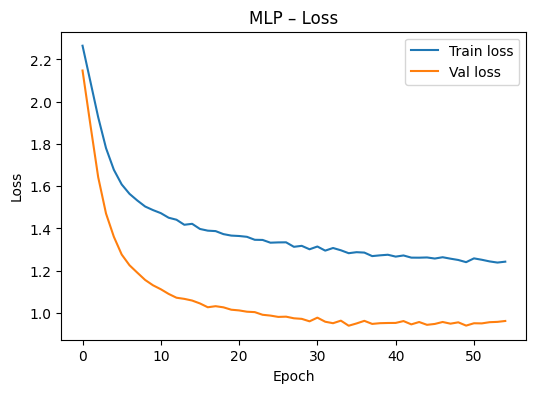

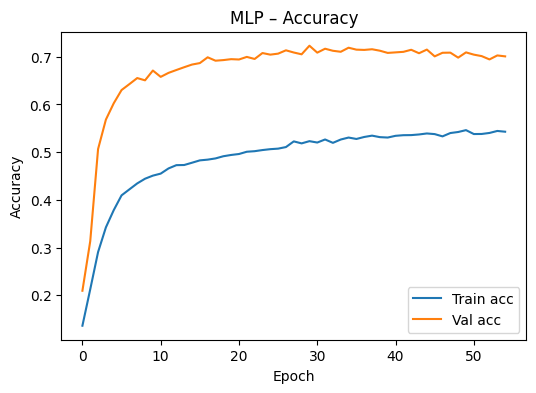

In [56]:
# Evaluate
y_pred_mlp = np.argmax(mlp_baseline.predict(X_test, verbose=1), axis=1)
mlp_metrics = evaluate_classifier_predictions(y_train, np.argmax(mlp_baseline.predict(X_train, verbose=0), axis=1),
                                              y_test,  y_pred_mlp, model_name="MLP_baseline")

# Plot learning curves
plt.figure(figsize=(6, 4))
plt.plot(hist_mlp.history["loss"], label="Train loss")
plt.plot(hist_mlp.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MLP - Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6, 4))
plt.plot(hist_mlp.history["accuracy"], label="Train acc")
plt.plot(hist_mlp.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("MLP - Accuracy"); plt.legend(); plt.show()

## 7. Baseline: XGBoost

=== XGB_baseline ===
Train accuracy: 0.9050
Test  accuracy: 0.9033
Train macro-F1: 0.9058
Test  macro-F1: 0.9043

Classification report (test set):
              precision    recall  f1-score   support

           0     0.8812    0.8824    0.8818       706
           1     0.9081    0.9646    0.9355       707
           2     0.8043    0.8966    0.8480       706
           3     0.9495    0.8937    0.9207       715
           4     0.9626    0.8617    0.9094       716
           5     0.9513    0.9085    0.9294       710
           6     0.9585    0.9761    0.9672       710
           7     0.9803    0.9775    0.9789       711
           8     0.8395    0.8197    0.8295       721
           9     0.8269    0.8581    0.8422       768

    accuracy                         0.9033      7170
   macro avg     0.9062    0.9039    0.9043      7170
weighted avg     0.9056    0.9033    0.9037      7170



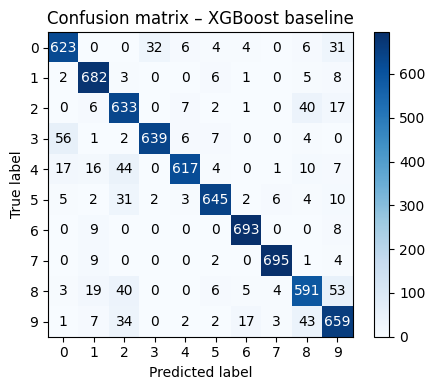

In [57]:
NUM_CLASSES = len(np.unique(y_dataset))

xgb_baseline = XGBClassifier(
    objective="multi:softprob",
    num_class=NUM_CLASSES,
    eval_metric="mlogloss",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

xgb_baseline.fit(X_train, y_train)
y_pred_xgb_train = xgb_baseline.predict(X_train)
y_pred_xgb_test  = xgb_baseline.predict(X_test)

xgb_metrics = evaluate_classifier_predictions(y_train, y_pred_xgb_train,
                                              y_test,  y_pred_xgb_test,
                                              model_name="XGB_baseline")

# Confusion matrix (XGB)
plot_confusion_matrix(xgb_metrics["confusion_matrix"],
                      class_labels=np.unique(y_dataset),
                      title="Confusion matrix - XGBoost baseline")


## 8. Model Design: Self-Attention on Joints (Transformer Encoder)

**Idea:** Treat each of the 21 joints as a **token** with 2 features (x, y). We first **project** each token to a `D_MODEL`-dim embedding, then apply **multi-head self-attention** and a **position-wise feed-forward network** inside a residual **Transformer encoder block**. Finally, we **pool** the 21 token embeddings (GlobalAveragePooling or a learnable `[CLS]` token) and feed a small classifier head.

**Why this helps:**
- **Self-attention** computes data-dependent weighted averages of other joints, letting a joint incorporate **context** from the whole hand.
- It models **long-range dependencies** (e.g., thumb ↔ little finger) without manually crafted features.
- Compared to an **MLP**, attention is **permutation-aware** due to the fixed joint ordering and can emphasize relevant pairwise relations.
- Compared to **tree ensembles** like XGBoost, attention learns **smooth geometric interactions** and is fully **differentiable** for end-to-end training.


### 8.1 Implementation (Keras)

We reshape inputs from `(42,)` to `(21, 2)` and define a lightweight Transformer encoder.


In [58]:
def build_transformer_classifier(
    num_joints=21,
    joint_dim=2,          # (x, y)
    d_model=64,           # token embedding dimension
    num_heads=4,
    ff_multiplier=2,      # MLP expansion ratio inside encoder
    num_layers=2,         # number of encoder blocks
    dropout_rate=0.1,
    num_classes=10,
    use_cls_token=False   # alternatively use GlobalAveragePooling
):
    inputs = keras.Input(shape=(num_joints*joint_dim,), name="flat_input")
    # reshape flat 42-dim to (21, 2)
    x = layers.Reshape((num_joints, joint_dim), name="reshape_tokens")(inputs)

    # Token projection: (21, 2) -> (21, d_model)
    x = layers.Dense(d_model, name="token_projection")(x)

    # (Optional) a small learnable joint-ID embedding via a simple index embedding
    # Create a sequence of indices [0..num_joints-1] and embed; then add to tokens.
    joint_ids = tf.range(num_joints)
    joint_emb_layer = layers.Embedding(input_dim=num_joints, output_dim=d_model, name="joint_id_embedding")
    joint_emb = joint_emb_layer(joint_ids)
    joint_emb = tf.expand_dims(joint_emb, axis=0)  # shape (1, 21, d_model)
    x = layers.Add(name="add_joint_id")([x, joint_emb])

    # Stack Transformer encoder layers
    for i in range(num_layers):
        # LayerNorm + MHA
        attn_input = layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{i}")(x)
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads,
                                                dropout=dropout_rate, name=f"mha_{i}")(attn_input, attn_input)
        x = layers.Add(name=f"res1_{i}")([x, attn_output])

        # LayerNorm + FFN
        ffn_input = layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{i}")(x)
        ffn_output = layers.Dense(d_model*ff_multiplier, activation="relu", name=f"ffn_dense1_{i}")(ffn_input)
        ffn_output = layers.Dropout(dropout_rate, name=f"ffn_dropout_{i}")(ffn_output)
        ffn_output = layers.Dense(d_model, name=f"ffn_dense2_{i}")(ffn_output)
        x = layers.Add(name=f"res2_{i}")([x, ffn_output])

    # Pool tokens to a single vector
    if use_cls_token:
        # Implement a learnable [CLS] token
        cls = tf.Variable(tf.random.normal([1, 1, d_model]), trainable=True, name="cls_token")
        cls_expanded = tf.tile(cls, [tf.shape(x)[0], 1, 1])
        x_with_cls = tf.concat([cls_expanded, x], axis=1)
        pooled = x_with_cls[:, 0, :]  # naive take-first token
    else:
        pooled = layers.GlobalAveragePooling1D(name="gap")(x)

    # Classification head
    head = layers.Dropout(dropout_rate, name="head_dropout")(pooled)
    logits = layers.Dense(num_classes, activation="softmax", name="head_dense")(head)

    model = keras.Model(inputs=inputs, outputs=logits, name="gesture_transformer")
    return model

transformer = build_transformer_classifier(
    num_joints=NUM_LANDMARKS,
    joint_dim=FEATURES_PER_LANDMARK,
    d_model=64,
    num_heads=4,
    ff_multiplier=2,
    num_layers=2,
    dropout_rate=0.1,
    num_classes=NUM_CLASSES,
    use_cls_token=False
)

transformer.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

transformer.summary()


Model: "gesture_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ flat_input          │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_tokens      │ (None, 21, 2)     │          0 │ flat_input[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_projection    │ (None, 21, 64)    │        192 │ reshape_tokens[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_joint_id (Add)  │ (1, 21, 64)       │          0 │ token_projection… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_0               │ (1, 21, 64)       │        128 │ add_joint_id[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_0               │ (1, 21, 64)       │     16,640 │ ln1_0[0][0],      │
│ (MultiHeadAttentio… │                   │            │ ln1_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_0 (Add)        │ (1, 21, 64)       │          0 │ add_joint_id[0][… │
│                     │                   │            │ mha_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_0               │ (1, 21, 64)       │        128 │ res1_0[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense1_0        │ (1, 21, 128)      │      8,320 │ ln2_0[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dropout_0       │ (1, 21, 128)      │          0 │ ffn_dense1_0[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense2_0        │ (1, 21, 64)       │      8,256 │ ffn_dropout_0[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2_0 (Add)        │ (1, 21, 64)       │          0 │ res1_0[0][0],     │
│                     │                   │            │ ffn_dense2_0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln1_1               │ (1, 21, 64)       │        128 │ res2_0[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_1               │ (1, 21, 64)       │     16,640 │ ln1_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ ln1_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1_1 (Add)        │ (1, 21, 64)       │          0 │ res2_0[0][0],     │
│                     │                   │            │ mha_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ln2_1               │ (1, 21, 64)       │        128 │ res1_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense1_1        │ (1, 21, 128)      │      8,320 │ ln2_1[0][0]       │
│ (Dense)             │                   │            │                 

 Total params: 67,786 (264.79 KB)

 Trainable params: 67,786 (264.79 KB)

 Non-trainable params: 0 (0.00 B)

### 8.2 Training

We use early stopping on validation loss and plot learning curves.


In [ ]:
es_attn = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

hist_attn = transformer.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=128,
    callbacks=[es_attn],
    verbose=1 # Changed from 0 to 1 to show progress
)

Epoch 1/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.2147 - loss: 2.1764 - val_accuracy: 0.3987 - val_loss: 1.6753
Epoch 2/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4552 - loss: 1.5312 - val_accuracy: 0.5976 - val_loss: 1.0955
Epoch 3/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6050 - loss: 1.0905 - val_accuracy: 0.7347 - val_loss: 0.7697
Epoch 4/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7136 - loss: 0.8231 - val_accuracy: 0.8195 - val_loss: 0.5505
Epoch 5/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7805 - loss: 0.6296 - val_accuracy: 0.8519 - val_loss: 0.4247
Epoch 6/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8284 - loss: 0.5070 - val_accuracy: 0.8863 - val_loss: 0.3368
Epoch 7/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8641 - loss: 0.4127 - val_accuracy: 0.9045 - val_loss: 0.2959
Epoch 8/300
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8802 - loss: 0.3593 - val_ac

In [ ]:
# Curves
plt.figure(figsize=(6, 4))
plt.plot(hist_attn.history["loss"], label="Train loss")
plt.plot(hist_attn.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Transformer - Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6, 4))
plt.plot(hist_attn.history["accuracy"], label="Train acc")
plt.plot(hist_attn.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Transformer - Accuracy"); plt.legend(); plt.show()

### 8.3 Evaluation (Accuracy, F1, Confusion Matrix)

We evaluate on the **held-out test set** to match earlier notebooks.


In [ ]:
y_pred_attn_train = np.argmax(transformer.predict(X_train, verbose=1), axis=1)
y_pred_attn_test  = np.argmax(transformer.predict(X_test,  verbose=1), axis=1)

attn_metrics = evaluate_classifier_predictions(
    y_train, y_pred_attn_train,
    y_test,  y_pred_attn_test,
    model_name="Transformer(Self-Attention)"
)

plot_confusion_matrix(attn_metrics["confusion_matrix"],
                      class_labels=np.unique(y_dataset),
                      title="Confusion matrix - Transformer(Self-Attention)")


## 9. Hyperparameter Tweaks (Ablation)

We try a few small variants to observe trends. **Note:** To keep runtime reasonable, we train for fewer epochs with early stopping.


In [ ]:
def train_eval_variant(d_model=64, heads=4, layers_n=2, dropout=0.1, epochs=120):
    tmp = build_transformer_classifier(
        num_joints=NUM_LANDMARKS,
        joint_dim=FEATURES_PER_LANDMARK,
        d_model=d_model,
        num_heads=heads,
        ff_multiplier=2,
        num_layers=layers_n,
        dropout_rate=dropout,
        num_classes=NUM_CLASSES,
        use_cls_token=False
    )
    tmp.compile(optimizer=keras.optimizers.Adam(3e-4),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
    es = keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, verbose=1)
    tmp.fit(X_train, y_train, validation_data=(X_test, y_test),
            epochs=epochs, batch_size=128, callbacks=[es], verbose=1)
    ypr_tr = np.argmax(tmp.predict(X_train, verbose=1), axis=1)
    ypr_te = np.argmax(tmp.predict(X_test,  verbose=1), axis=1)
    metrics = evaluate_classifier_predictions(y_train, ypr_tr, y_test, ypr_te,
                                              model_name=f"TX(d={d_model},h={heads},L={layers_n})")
    return {
        "name": f"d{d_model}_h{heads}_L{layers_n}",
        "test_acc": metrics["test_accuracy"],
        "test_macro_f1": metrics["test_macro_f1"]
    }

variants = [
    (64, 4, 2),
    (96, 4, 2),
    (64, 8, 2),
    (64, 4, 3),
]

variant_records = []
for d, h, L in variants:
    print("-"*60)
    record = train_eval_variant(d_model=d, heads=h, layers_n=L, epochs=120)
    variant_records.append(record)


In [ ]:
ablation_df = pd.DataFrame(variant_records).sort_values("test_acc", ascending=False)
ablation_df

## 10. Evaluation & Comparison

We summarise **test set metrics** across models trained in this notebook and present a bar chart for quick comparison.


In [ ]:
summary_df = pd.DataFrame([
    {"model": "MLP_baseline", "test_acc": mlp_metrics["test_accuracy"], "test_macro_f1": mlp_metrics["test_macro_f1"]},
    {"model": "XGB_baseline", "test_acc": xgb_metrics["test_accuracy"], "test_macro_f1": xgb_metrics["test_macro_f1"]},
    {"model": "Transformer(Self-Attention)", "test_acc": attn_metrics["test_accuracy"], "test_macro_f1": attn_metrics["test_macro_f1"]},
])

display(summary_df.sort_values("test_acc", ascending=False))

plt.figure(figsize=(7, 4))
plt.bar(summary_df["model"], summary_df["test_acc"])
plt.ylim(0, 1.0)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Test Accuracy")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.bar(summary_df["model"], summary_df["test_macro_f1"])
plt.ylim(0, 1.0)
plt.ylabel("Test Macro-F1")
plt.title("Model Comparison - Test Macro-F1")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## 11. Discussion: Use Cases, Limitations, and Trade-offs

**When to prefer the Transformer over MLP/XGBoost**
- You expect **inter-joint relations** to matter (e.g., angles/distances capturing fine-grained shapes).
- You want a **compact, fully differentiable** model deployable on-device (e.g., TFLite) with hardware-accelerated ops.

**When baselines may suffice**
- **MLP**: very fast & tiny; performs well when the signal is strong without complex relationships.
- **XGBoost**: robust with little tuning; can perform strongly with tabular data; easy to interpret feature importance.

**Costs and constraints**
- Transformers add **attention layers** with O(N²) interactions over 21 tokens — still cheap for 21, but heavier than an MLP.
- Slightly more sensitive to hyperparameters; use **early stopping** & **dropout** to regularise.

**Practicality**
- For real-time webcam pipelines, a small Transformer (e.g., `d_model=64`, `heads=4`, `layers=2`) is typically **<1-2 ms** per sample on modern GPUs and tens of ms on CPU depending on hardware. Batch-1 inference is standard for streaming.


## 12. Deployment Considerations (TFLite)

Exporting to **TensorFlow Lite** mirrors the prior MLP notebook. Quantisation can reduce size/latency with minimal accuracy loss.


In [ ]:
# Convert the Transformer to TFLite (quantized) - optional
save_dir = "models/keypoint" # "../models/keypoint"
os.makedirs(save_dir, exist_ok=True)
keras_path  = os.path.join(save_dir, f"keypoint_classifier_transformer_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.keras")
tflite_path = os.path.join(save_dir, f"keypoint_classifier_transformer_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.tflite")

# Save the Keras model without optimizer state (slightly smaller)
transformer.save(keras_path, include_optimizer=False)

converter = tf.lite.TFLiteConverter.from_keras_model(transformer)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # enables post-training quantization
tflite_quant_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_quant_model)

print("Saved Keras model to:", keras_path)
print("Saved TFLite model to:", tflite_path)


### Appendix: Quick Keypoint Visualiser (optional)


In [ ]:
def plot_hand_keypoints(sample, num_landmarks=21, title="Hand keypoints"):
    pts = sample.reshape(num_landmarks, 2)
    xs, ys = pts[:,0], pts[:,1]
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(xs, ys)
    for i,(x,y) in enumerate(pts):
        plt.text(x, y, str(i), fontsize=7)
    plt.gca().invert_yaxis()
    plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout(); plt.show()

# Example:
# plot_hand_keypoints(X_dataset[0], title=f"Label {y_dataset[0]}")
